In [6]:
from generate_data import Data
from evaluate import *
from models import *

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [9]:
%%time
data = Data(layer_size=16)

Wall time: 658 ms


c:\Users\juand\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


In [10]:
%%time
train, val, test = data.get_splits(['skip'], [19])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 209 train | 752 val | 3008 test
Wall time: 334 ms


#### Peek at unshuffled train data

In [11]:
train_original[:20]

[[',..._.._,.___._.', 'w,,_,.,_,__.._.,', 'cr__,._,._,._,__', False],
 ['__,..._,,.,,.__,', ',w_,,,,._.___.,,', '__.,cr._...,_,.,', False],
 ['.._,,,_.__,_.,._', '_.w....,.,,___,.', '__,,.___cr,,..,.', False],
 [',,,_,___.,._,___', '_,_w,,,,.,,,.,__', ',_,,____.,,.cr_,', False],
 ['..,__,,.,.....,_', '.__._w.,,,.,__,,', ',cr,.,__,____,,_', False],
 ['_,.,___,,...,.__', '__,...w_,,_._,_,', '.,.,.cr..,,._._,', False],
 ['.,_,_,_,._,..,.,', '_,..,_,w.__,.,__', '.__,,_,,,cr_,.,_', False],
 [',_,...,.,_,_.._.', '_____,_.w_._.__.', '_.,,,____._.,cr_', False],
 ['.___,,,_,_.._,..', ',____,.,._w____.', '_.cr,....,,.__,.', False],
 ['_,._,,__,.,..,_.', ',...,,,_,_,w__,_', '._.,_.cr_,,_,,_,', False],
 ['._,.._._,,...._.', '___,__,.__.,w_.,', ',..._,.._,cr.,..', False],
 [',,_,_,.,,.,,,,_.', '_..__,,._....w_,', '.,__,_,.,,..._cr', False],
 ['_,_,._,__,,__...', ',,__..,_,_..,.,w', '._,cr_..___.._.,', False],
 [',,.,_,,..__._,,.', 'w_._....,_.,,,.,', '___.,_.dr_._,_,,', True],
 [',,,,,.,._,,_,._,',

In [12]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 12 | F2-uw 12 | F2-w 13 | F2-noop 14 | 
F3 cr:    F2-wu 11 | F2-uw 12 | F2-w 13 | F2-noop 13 | 
F3 r:    F2-wu 13 | F2-uw 13 | F2-w 13 | F2-noop 14 | 
F3 noop:    F2-wu 13 | F2-uw 13 | F2-w 15 | F2-noop 15 | 

Positive samples count: 92
Total samples count: 209
Positive class ratio: 0.44019138755980863


#### Peek at test data

In [13]:
test_original[:15]

[['._,_,_.,,_,_.,_,', '..,_,,w.__,__.,_', '.,.,_.,.dr,.,.__', True],
 [',,.,.,,.,_._.._,', '__,w_,,,_,,,_,_,', ',_.,_.__,,__.,.,', False],
 ['.,,,____,,,..__.', 'w_,._._..._...._', ',,..,,_..dr,_,_.', True],
 ['.,_.,,_,.,,_,._.', ',,,,_,__,_..,,..', ',,.,,_,_.,.,___.', False],
 ['.___,___,___.,..', '..wu._,,.,__,,._', '___,,_.dr__,,___', False],
 [',.,.,__._._._._.', '.,_.._..wu,_,.,,', '.cr_,,_._,.,,.,_', False],
 [',.,,,,...___._,,', '_._.w_.__,.__.,.', ',_..,,_.,__.,,_r', True],
 ['__,.__._,,._.,__', '_,.._.__._._,uw,', '...,__,..___,___', False],
 ['_,,.._,,.__,.,__', '___,_w_____,._.,', '_,,,_.,__,,,_r.,', True],
 ['.._,_,_,._..._,_', ',,_,._,_.,.wu.,_', '__,_._.,,..dr.._', False],
 [',.,_,...___,,.,,', '_,,_,,,,._,____,', '..,.,,.,..__,.,,', False],
 ['__,,.,__,__,_,,,', '.._,__.,wu_._.__', '.,_,,.,_.__dr.,,', False],
 ['._,..,,.__.._.__', '..,_w..__._,__.,', 'cr.,,_.,.._,_,..', False],
 ['_.,_,._,.,...,,.', '..,,..,,.,._..._', '_....,._.,.,,cr.', False],
 ['_,.,._,._,.,,._,', ',

In [14]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 175 | F2-uw 177 | F2-w 179 | F2-noop 197 | 
F3 cr:    F2-wu 177 | F2-uw 171 | F2-w 179 | F2-noop 204 | 
F3 r:    F2-wu 184 | F2-uw 175 | F2-w 200 | F2-noop 210 | 
F3 noop:    F2-wu 177 | F2-uw 201 | F2-w 192 | F2-noop 210 | 

Positive samples count: 1322
Total samples count: 3008
Positive class ratio: 0.43949468085106386


#### Peek at val data

In [15]:
val_original[:15]

[['__,__,._.___,,,.', '__._,uw_____._._', ',,___.___.dr,._.', True],
 ['..__.._..__,.._,', '...,wu.._._,.__.', '._,_____._.,.,,_', False],
 ['_,__,,,__,_,_._,', ',__,...,w.__,___', '.,,,,__r,_,.._,.', True],
 ['.._,__..,.,_.,_.', '.,.__.._..__.__.', '.....,._.,_r__,.', True],
 [',.___,_..,,____,', ',_,._,__.w,___.,', '...dr__.,,_____.', True],
 ['_,,._.._._,_..,,', '_,,__.,,,,._.uw.', '.__,,.,,cr_.__,_', False],
 [',.,.,,._,_____,_', ',_._._,,,uw,._._', '__..._.._,_,,,_,', False],
 ['_...,..,._.,_.__', ',.__..._....,___', '._._._.__,.._,__', False],
 [',,_,_.._...,.,,_', '..uw__._.,_.,..,', ',_.._..dr..,,.__', True],
 [',..,.,___.._,_.,', '__,__,,,._.,___.', ',.....dr,,,..,_.', True],
 ['..._,._,.._..,,,', ',_,_..,,..,,,.._', '.__,_,.,,_..,,_.', False],
 ['_,,._,.,,..,,_.,', '__,,.._.wu___,..', '._,_.,,.__,,,...', False],
 [',,,_,_,,.,.,,,..', ',_._......w__,.,', '.__.,..,.,.,.,.r', True],
 ['._._,.,.__,.__,.', '..,,,,,._,__,,wu', ',.,_,.r___.,_,_,', True],
 ['_,___,_..,...._,', '_,.,_

In [16]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 38 | F2-uw 36 | F2-w 48 | F2-noop 44 | 
F3 cr:    F2-wu 37 | F2-uw 42 | F2-w 48 | F2-noop 38 | 
F3 r:    F2-wu 43 | F2-uw 52 | F2-w 43 | F2-noop 48 | 
F3 noop:    F2-wu 65 | F2-uw 41 | F2-w 65 | F2-noop 64 | 

Positive samples count: 314
Total samples count: 752
Positive class ratio: 0.4175531914893617


#### Send label arrays to device

In [17]:
y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
y_test = torch.from_numpy(y_test.astype(float)).float().to(device)

#### Get data in normal format (same as CNN format)

In [18]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [19]:
x_train_normal[0].shape

torch.Size([209, 128])

#### Get data in convolutional format, send to device

In [20]:
x_train_cnn = data.to_conv_format(x_train)
x_val_cnn = data.to_conv_format(x_val)
x_test_cnn = data.to_conv_format(x_test)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [21]:
x_train_cnn[0].shape

torch.Size([209, 128])

#### Get data in LSTM format, send to device

In [22]:
x_train_lstm = data.to_lstm_format(x_train)
x_val_lstm = data.to_lstm_format(x_val)
x_test_lstm = data.to_lstm_format(x_test)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [23]:
x_train_lstm[0].shape

torch.Size([209, 16, 8])

### Define training parameters

In [24]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100
experiment_name = "skip19"

### Define training procedure for each model

In [32]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    wrong_preds = []
    best_accuracy = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(1-pos_train_ratio)/pos_train_ratio]).to(device))
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./temp/{model_name}_model_TEMP_{experiment_name}')    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break


        model.load_state_dict(torch.load(f'./temp/{model_name}_model_TEMP_{experiment_name}'))

        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original))
        precisions.append(get_precision(model, x_test, y_test, test_original))
        recalls.append(get_recall(model, x_test, y_test, test_original))
        f1s.append(get_f1(precisions[-1], recalls[-1]))
        wrong_preds.append(get_wrong_predictions(model, x_test, y_test, test_original))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./bestmodels/best_{model_name}_model_{experiment_name}')    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | Current model test accuracy:", accuracies[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test precision:", precisions[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test recall:", recalls[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test f1:", f1s[-1]['Overall'])
    return accuracies, precisions, recalls, f1s, wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [33]:
%%time
cnn_accuracies, cnn_precisions, cnn_recalls, cnn_f1s, cnn_wrong_preds, cnn_epoch_stats = train_models(CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.0001, data, 64, 128, 4, -1, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_45144\3365763532.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.957779255319149
1 / 20 models trained | Current model test precision: 0.9307858687815429
1 / 20 models trained | Current model test recall: 0.9765506807866868
1 / 20 models trained | Current model test f1: 0.9531192321889996
2 / 20 models trained | Current model test accuracy: 0.9521276595744681
2 / 20 models trained | Current model test precision: 0.9237410071942446
2 / 20 models trained | Current model test recall: 0.9712556732223904
2 / 20 models trained | Current model test f1: 0.9469026548672567
3 / 20 models trained | Current model test accuracy: 0.9621010638297872
3 / 20 models trained | Current model test precision: 0.9326647564469914
3 / 20 models trained | Current model test recall: 0.9848714069591528
3 / 20 models trained | Current model test f1: 0.9580573951434879
4 / 20 models trained | Current model test accuracy: 0.9371675531914894
4 / 20 models trained | Current model test precision: 0.8851121685927941
4 / 20 models

In [34]:
%%time
lstm_accuracies, lstm_precisions, lstm_recalls, lstm_f1s, lstm_wrong_preds, lstm_epoch_stats = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_45144\3365763532.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.9414893617021277
1 / 20 models trained | Current model test precision: 0.8830213903743316
1 / 20 models trained | Current model test recall: 0.9992435703479576
1 / 20 models trained | Current model test f1: 0.9375443577004967
2 / 20 models trained | Current model test accuracy: 0.941156914893617
2 / 20 models trained | Current model test precision: 0.882943143812709
2 / 20 models trained | Current model test recall: 0.9984871406959153
2 / 20 models trained | Current model test f1: 0.9371671991480298
3 / 20 models trained | Current model test accuracy: 0.9398271276595744
3 / 20 models trained | Current model test precision: 0.8826291079812206
3 / 20 models trained | Current model test recall: 0.9954614220877458
3 / 20 models trained | Current model test f1: 0.9356558833985069
4 / 20 models trained | Current model test accuracy: 0.9418218085106383
4 / 20 models trained | Current model test precision: 0.8830995323981295
4 / 20 models 

In [35]:
%%time
deepset_accuracies, deepset_precisions, deepset_recalls, deepset_f1s, deepset_wrong_preds, deepset_epoch_stats = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_45144\3365763532.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.6303191489361702
1 / 20 models trained | Current model test precision: 0.5835987261146497
1 / 20 models trained | Current model test recall: 0.5544629349470499
1 / 20 models trained | Current model test f1: 0.5686578743211792
2 / 20 models trained | Current model test accuracy: 0.598404255319149
2 / 20 models trained | Current model test precision: 0.5431164901664145
2 / 20 models trained | Current model test recall: 0.5431164901664145
2 / 20 models trained | Current model test f1: 0.5431164901664145
3 / 20 models trained | Current model test accuracy: 0.621343085106383
3 / 20 models trained | Current model test precision: 0.5984930032292788
3 / 20 models trained | Current model test recall: 0.4205748865355522
3 / 20 models trained | Current model test f1: 0.49400266548200805
4 / 20 models trained | Current model test accuracy: 0.6126994680851063
4 / 20 models trained | Current model test precision: 0.5628502802241794
4 / 20 models

In [36]:
%%time
deepsetv2_accuracies, deepsetv2_precisions, deepsetv2_recalls, deepsetv2_f1s, deepsetv2_wrong_preds, deepsetv2_epoch_stats = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_45144\3365763532.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.43949468085106386
1 / 20 models trained | Current model test precision: 0.43949468085106386
1 / 20 models trained | Current model test recall: 1.0
1 / 20 models trained | Current model test f1: 0.6106235565819862
2 / 20 models trained | Current model test accuracy: 0.43949468085106386
2 / 20 models trained | Current model test precision: 0.43949468085106386
2 / 20 models trained | Current model test recall: 1.0
2 / 20 models trained | Current model test f1: 0.6106235565819862
3 / 20 models trained | Current model test accuracy: 0.43949468085106386
3 / 20 models trained | Current model test precision: 0.43949468085106386
3 / 20 models trained | Current model test recall: 1.0
3 / 20 models trained | Current model test f1: 0.6106235565819862
4 / 20 models trained | Current model test accuracy: 0.43949468085106386
4 / 20 models trained | Current model test precision: 0.43949468085106386
4 / 20 models trained | Current model test recall

In [37]:
%%time
feedforward_accuracies, feedforward_precisions, feedforward_recalls, feedforward_f1s, feedforward_wrong_preds, feedforward_epoch_stats = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_45144\3365763532.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.621343085106383
1 / 20 models trained | Current model test precision: 0.5722178374112076
1 / 20 models trained | Current model test recall: 0.5484114977307111
1 / 20 models trained | Current model test f1: 0.5600617999227501
2 / 20 models trained | Current model test accuracy: 0.5834441489361702
2 / 20 models trained | Current model test precision: 0.5278900565885206
2 / 20 models trained | Current model test recall: 0.4939485627836611
2 / 20 models trained | Current model test f1: 0.5103556076592418
3 / 20 models trained | Current model test accuracy: 0.5957446808510638
3 / 20 models trained | Current model test precision: 0.5414710485133021
3 / 20 models trained | Current model test recall: 0.5234493192133132
3 / 20 models trained | Current model test f1: 0.5323076923076924
4 / 20 models trained | Current model test accuracy: 0.5964095744680851
4 / 20 models trained | Current model test precision: 0.541033434650456
4 / 20 models 

# Evaluation

### Get best 50% performing models

In [38]:
top_half = int(num_experiments / 2)
best_cnn_accs = filter_top_k_accuracies(cnn_accuracies, top_half)
best_lstm_accs = filter_top_k_accuracies(lstm_accuracies, top_half)
best_deepset_accs = filter_top_k_accuracies(deepset_accuracies, top_half)
best_deepsetv2_accs = filter_top_k_accuracies(deepsetv2_accuracies, top_half)
best_feedforward_accs = filter_top_k_accuracies(feedforward_accuracies, top_half)

## Accuracy breakdown by cases for all the models

In [39]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [40]:
get_stats_df(all_accuracies, model_names, test_original)

,Overall,cr_noop,cr_uw,cr_w,cr_wu,dr_noop,dr_uw,dr_w,dr_wu,noop_noop,noop_uw,noop_w,noop_wu,r_noop,r_uw,r_w,r_wu
CNN,95.6%,100.0%,100.0%,100.0%,100.0%,98.9%,97.6%,96.8%,38.0%,99.9%,100.0%,100.0%,100.0%,100.0%,99.8%,99.9%,93.3%
LSTM,94.3%,100.0%,100.0%,100.0%,100.0%,100.0%,99.1%,99.9%,5.8%,99.9%,100.0%,99.9%,99.9%,99.9%,99.2%,99.6%,98.3%
DeepSet(like in paper),61.7%,71.9%,73.9%,72.3%,73.4%,58.8%,55.2%,52.1%,47.6%,72.0%,72.9%,74.5%,73.0%,51.4%,45.3%,48.1%,43.7%
DeepSet(sum at start),43.9%,0.0%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,100.0%
Feedforward,60.6%,72.6%,76.0%,74.5%,75.0%,55.1%,50.7%,48.3%,50.9%,72.5%,73.9%,74.6%,73.0%,46.1%,40.8%,44.8%,40.4%
Sample count,3008,204,171,179,177,197,177,179,175,210,201,192,177,210,175,200,184


## Accuracy breakdown by cases for top 50% of models

In [41]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['dr', 'r', 'cr', 'noop']

In [42]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN,96.1%,100.0%,85.9%,100.0%,98.2%
LSTM,94.6%,100.0%,78.0%,100.0%,99.7%
DeepSet(like in paper),63.4%,74.1%,54.6%,76.1%,48.6%
DeepSet(sum at start),43.9%,0.0%,76.0%,0.0%,100.0%
Feedforward,62.5%,72.1%,55.8%,71.6%,50.6%
Sample count,3008,731,728,780,769


In [43]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['r', 'cr', 'noop']

In [44]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,dr_noop,dr_uw,dr_w,dr_wu,f3_cr,f3_noop,f3_r
CNN,96.1%,99.7%,98.4%,97.6%,45.5%,100.0%,100.0%,98.2%
LSTM,94.6%,100.0%,98.4%,100.0%,9.9%,100.0%,100.0%,99.7%
DeepSet(like in paper),63.4%,60.6%,57.4%,55.0%,44.5%,74.1%,76.1%,48.6%
DeepSet(sum at start),43.9%,100.0%,100.0%,100.0%,0.0%,0.0%,0.0%,100.0%
Feedforward,62.5%,63.1%,59.4%,57.2%,42.6%,72.1%,71.6%,50.6%
Sample count,3008,197,177,179,175,731,780,769


## Accuracies per CNN model

In [45]:
get_stats_per_model(cnn_accuracies, ['CNN #' + str(i) for i in range(len(cnn_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN #0,95.8%,100.0%,85.3%,100.0%,97.4%
CNN #1,95.2%,100.0%,81.2%,100.0%,99.1%
CNN #2,96.2%,100.0%,86.5%,100.0%,97.9%
CNN #3,93.7%,100.0%,74.9%,100.0%,99.2%
CNN #4,95.8%,100.0%,84.6%,100.0%,98.0%
CNN #5,94.9%,100.0%,80.8%,100.0%,98.2%
CNN #6,95.2%,100.0%,81.0%,100.0%,99.1%
CNN #7,96.0%,100.0%,85.6%,100.0%,97.9%
CNN #8,95.3%,100.0%,82.6%,100.0%,98.3%
CNN #9,94.9%,100.0%,80.4%,100.0%,98.6%


## Accuracies per LSTM model

In [46]:
get_stats_per_model(lstm_accuracies, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
LSTM #0,94.1%,100.0%,76.0%,100.0%,99.9%
LSTM #1,94.1%,100.0%,76.0%,100.0%,99.7%
LSTM #2,94.0%,100.0%,76.0%,100.0%,99.2%
LSTM #3,94.2%,100.0%,76.0%,100.0%,100.0%
LSTM #4,93.8%,100.0%,77.9%,100.0%,96.6%
LSTM #5,97.1%,100.0%,88.2%,100.0%,99.7%
LSTM #6,94.2%,100.0%,76.0%,100.0%,100.0%
LSTM #7,94.2%,100.0%,76.0%,100.0%,100.0%
LSTM #8,94.1%,100.0%,76.1%,100.0%,99.7%
LSTM #9,94.2%,100.0%,76.0%,100.0%,100.0%


## Accuracies per DeepSets V1 model

In [47]:
get_stats_per_model(deepset_accuracies, ['DeepSet(like in paper) #' + str(i) for i in range(len(deepset_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(like in paper) #0,63.0%,69.2%,55.4%,75.5%,51.8%
DeepSet(like in paper) #1,59.8%,68.8%,56.3%,63.8%,50.6%
DeepSet(like in paper) #2,62.1%,77.0%,50.1%,84.0%,37.2%
DeepSet(like in paper) #3,61.3%,72.4%,54.3%,68.8%,49.7%
DeepSet(like in paper) #4,64.1%,70.9%,54.9%,77.8%,52.5%
DeepSet(like in paper) #5,63.9%,78.1%,58.7%,70.3%,49.0%
DeepSet(like in paper) #6,60.5%,66.6%,55.2%,68.1%,52.0%
DeepSet(like in paper) #7,63.7%,73.6%,53.4%,79.4%,48.1%
DeepSet(like in paper) #8,59.2%,68.7%,53.6%,67.4%,47.3%
DeepSet(like in paper) #9,61.1%,74.1%,55.2%,67.8%,47.6%


## Accuracies per DeepSets V2 model

In [48]:
get_stats_per_model(deepsetv2_accuracies, ['DeepSet(sum at start) #' + str(i) for i in range(len(deepsetv2_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(sum at start) #0,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #1,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #2,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #3,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #4,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #5,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #6,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #7,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #8,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #9,43.9%,0.0%,76.0%,0.0%,100.0%


## Accuracies per FeedForward model

In [49]:
get_stats_per_model(feedforward_accuracies, ['Feedforward #' + str(i) for i in range(len(feedforward_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
Feedforward #0,62.1%,69.1%,57.4%,72.4%,49.5%
Feedforward #1,58.3%,67.0%,53.8%,65.3%,47.3%
Feedforward #2,59.6%,66.5%,53.6%,68.8%,49.3%
Feedforward #3,59.6%,68.9%,54.1%,65.4%,50.2%
Feedforward #4,61.7%,66.2%,54.1%,73.1%,53.2%
Feedforward #5,63.3%,77.6%,54.8%,75.9%,45.0%
Feedforward #6,60.6%,77.4%,51.9%,71.7%,41.6%
Feedforward #7,61.5%,71.5%,58.0%,64.1%,52.5%
Feedforward #8,61.2%,69.4%,55.1%,66.9%,53.6%
Feedforward #9,61.2%,72.5%,55.1%,69.5%,48.0%


# Training evolution

### CNN

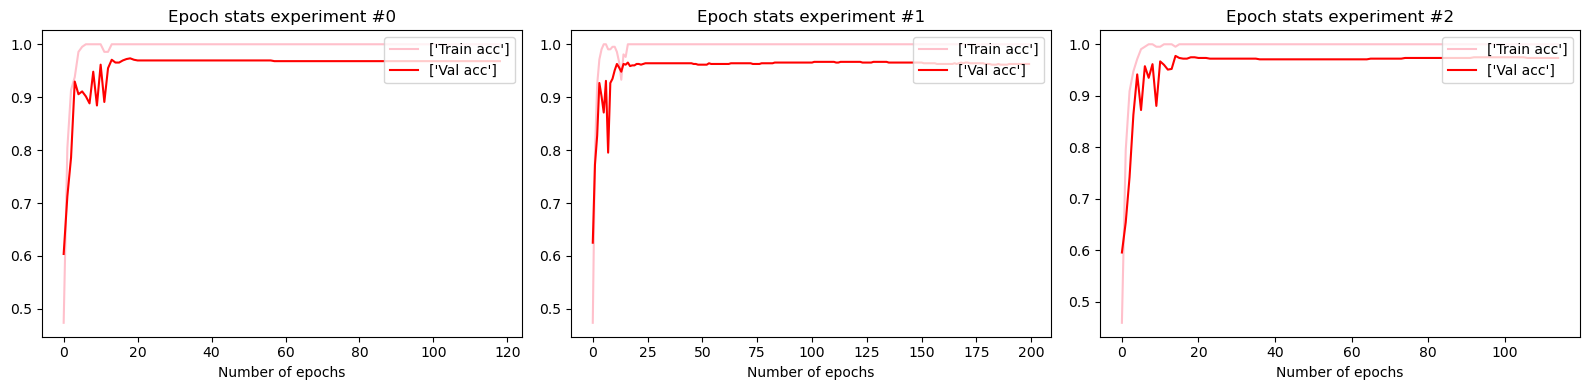

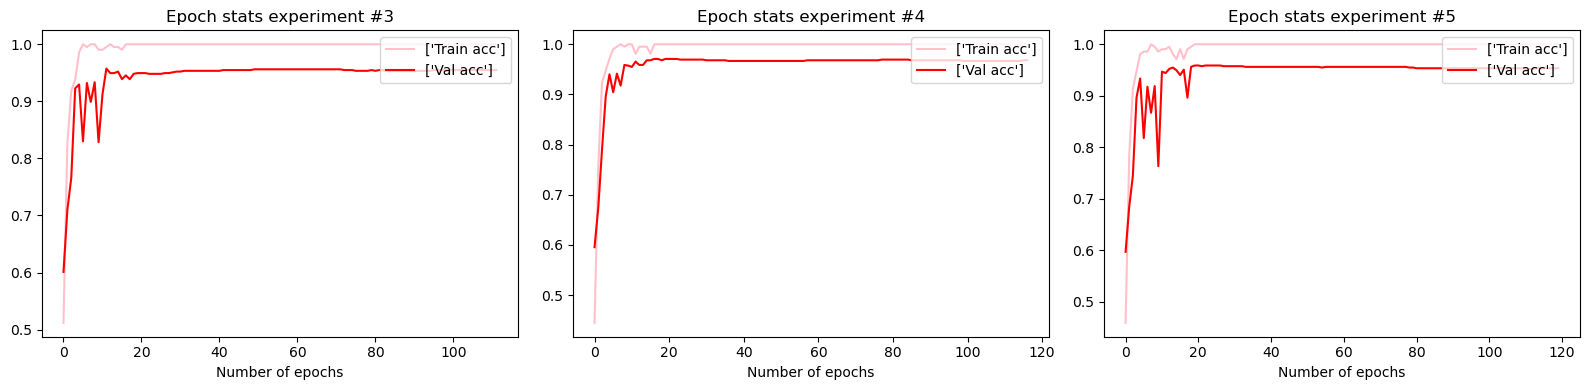

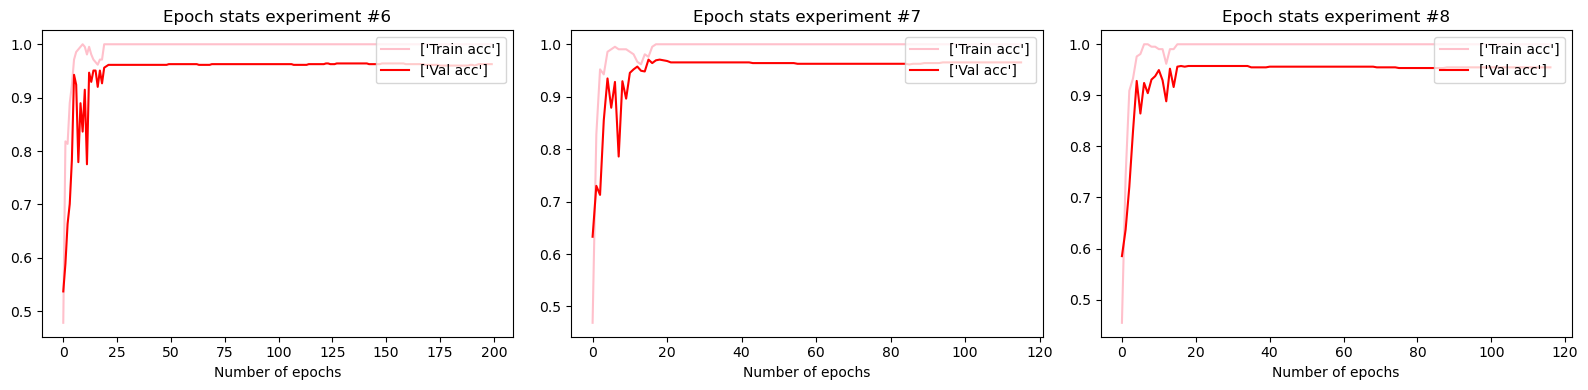

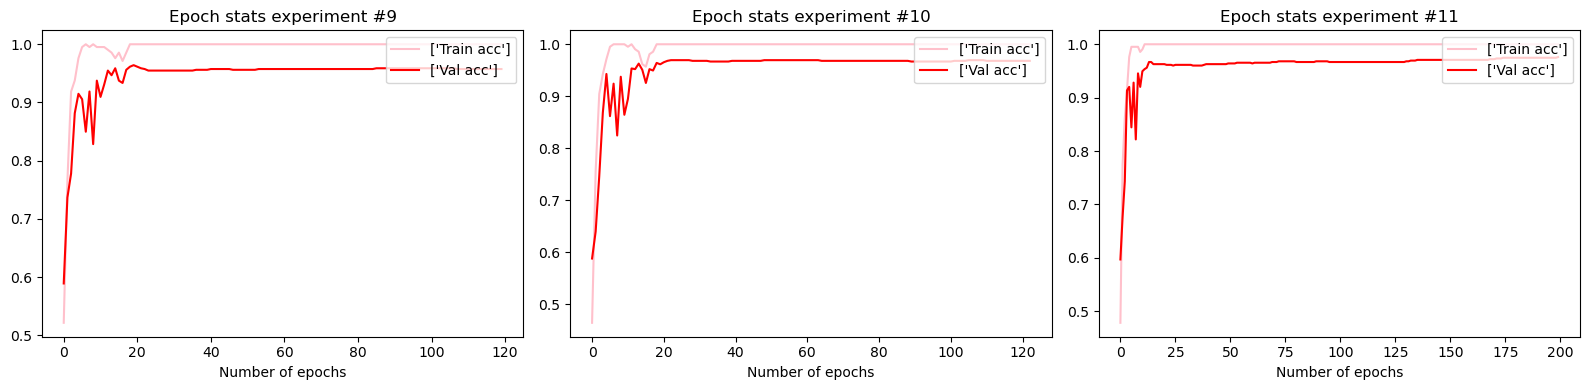

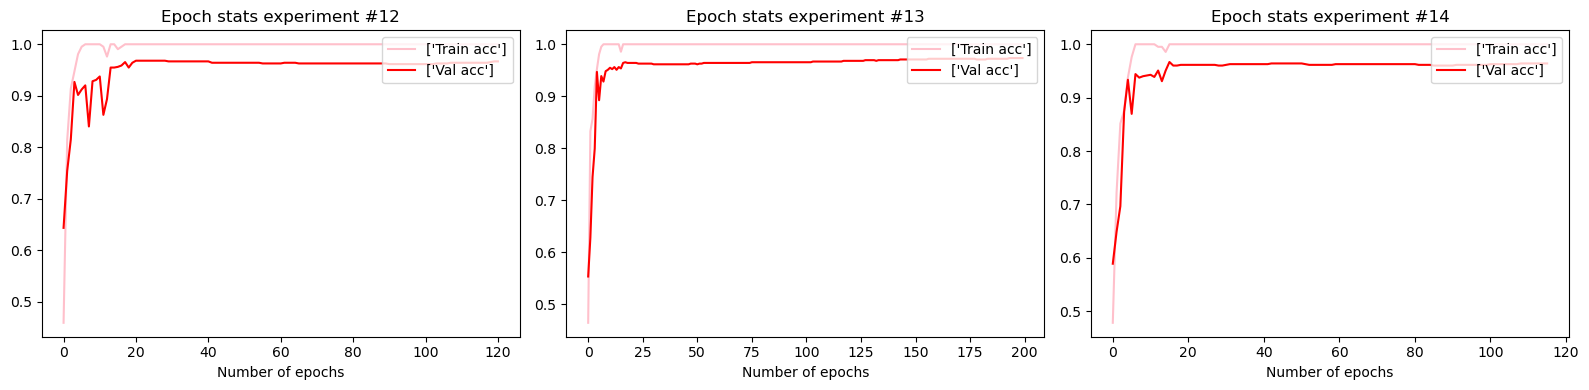

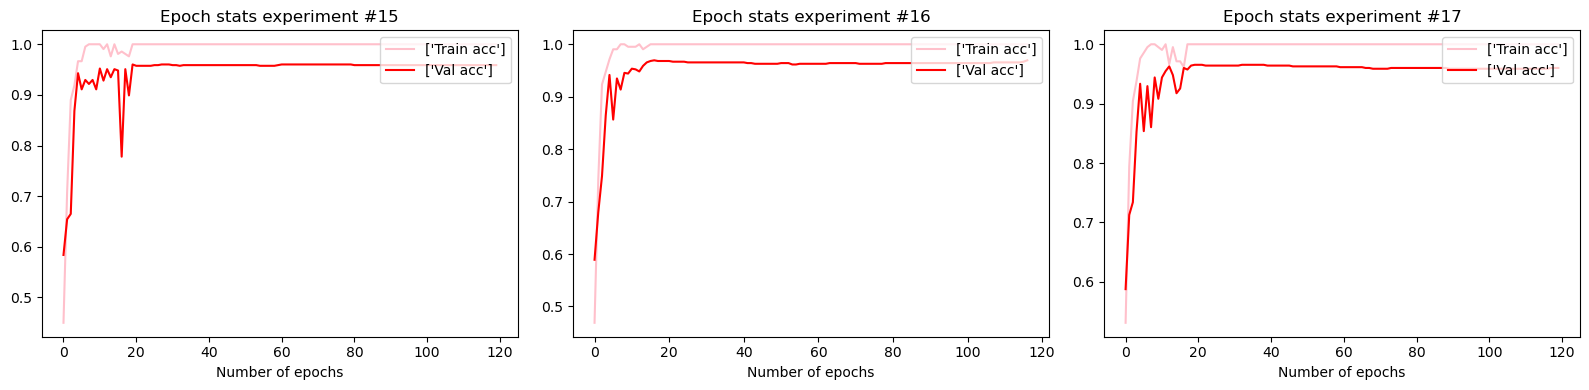

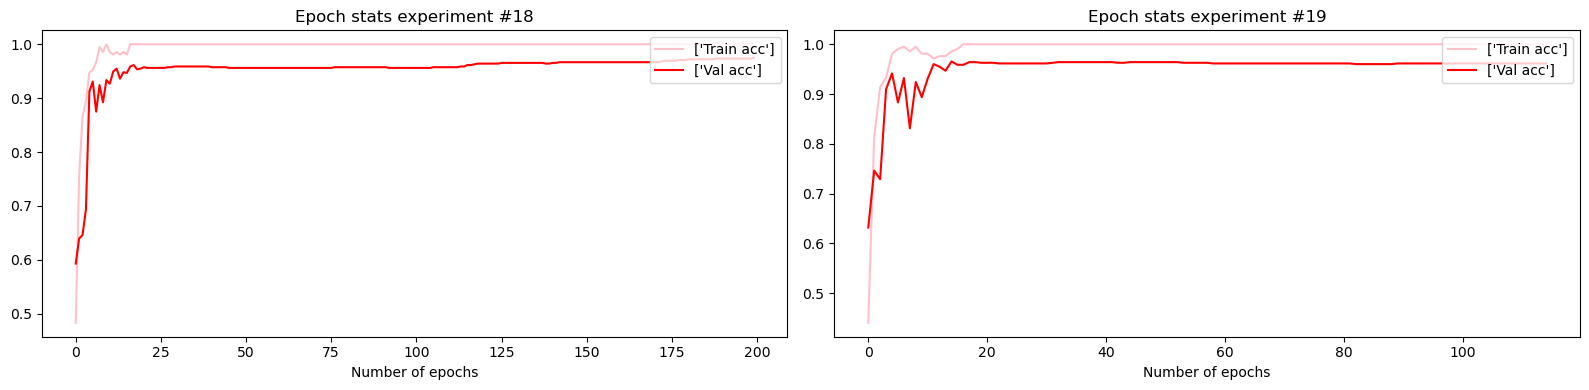

In [50]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

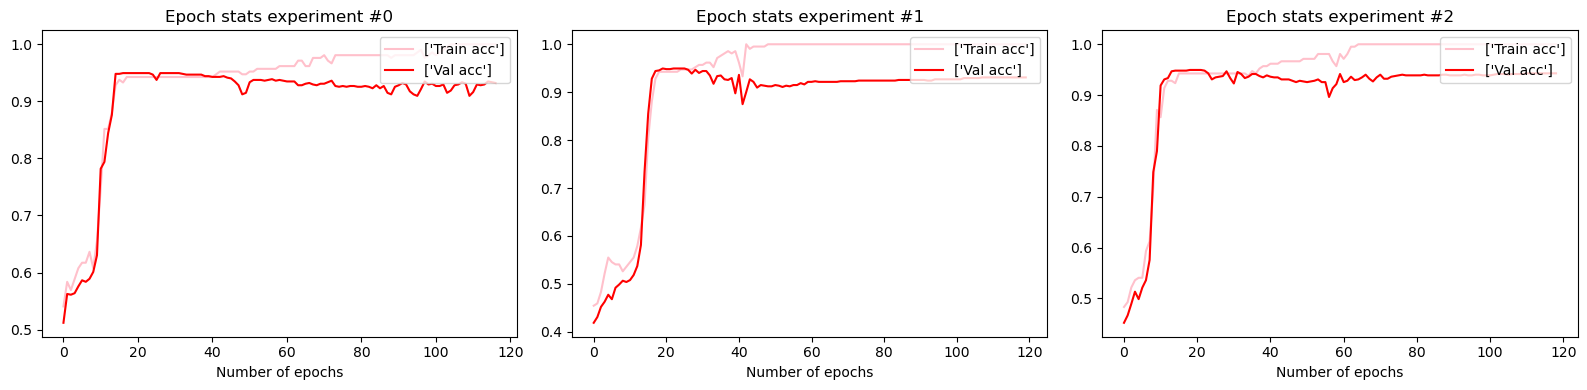

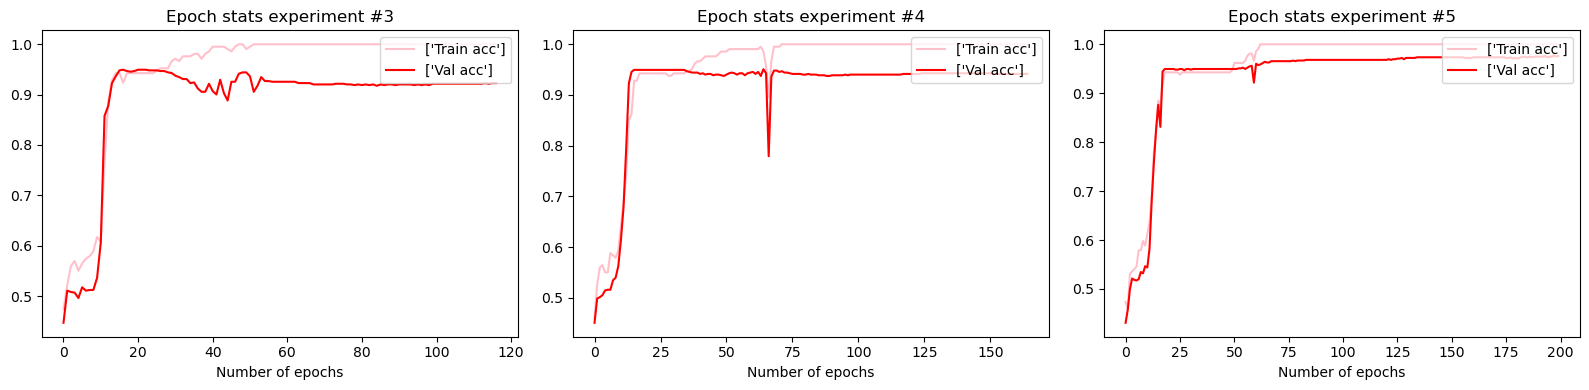

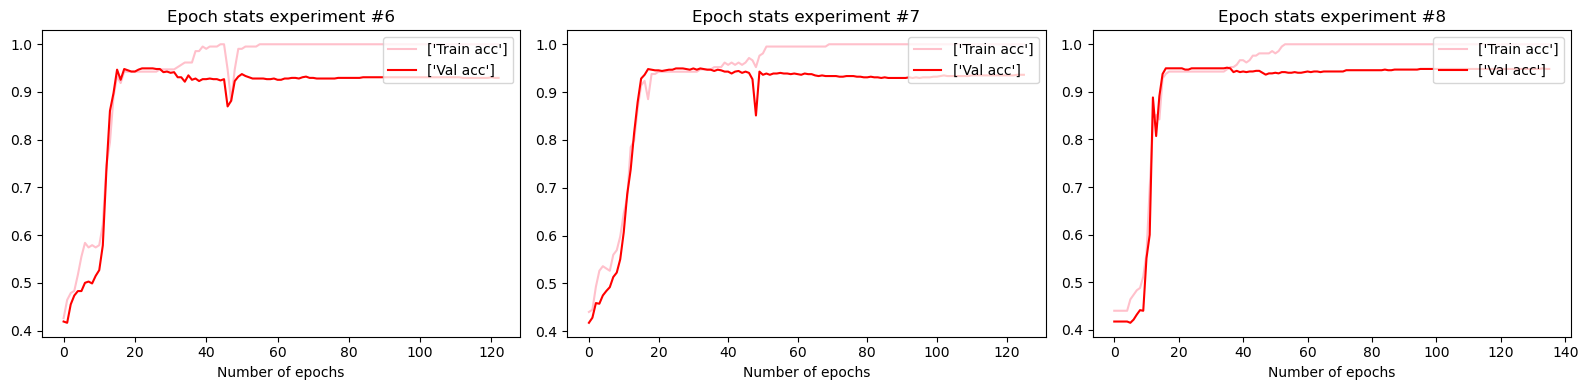

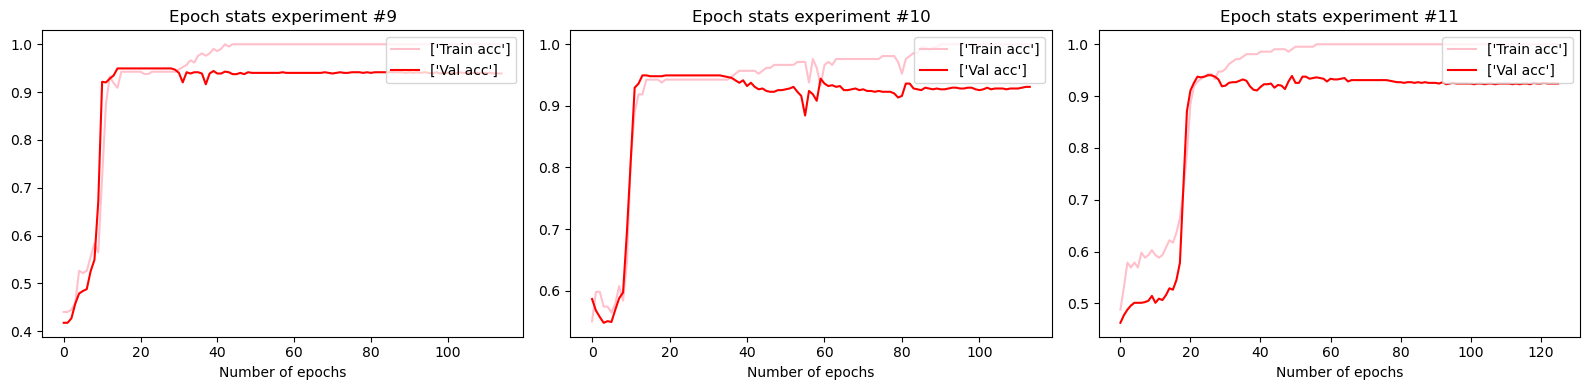

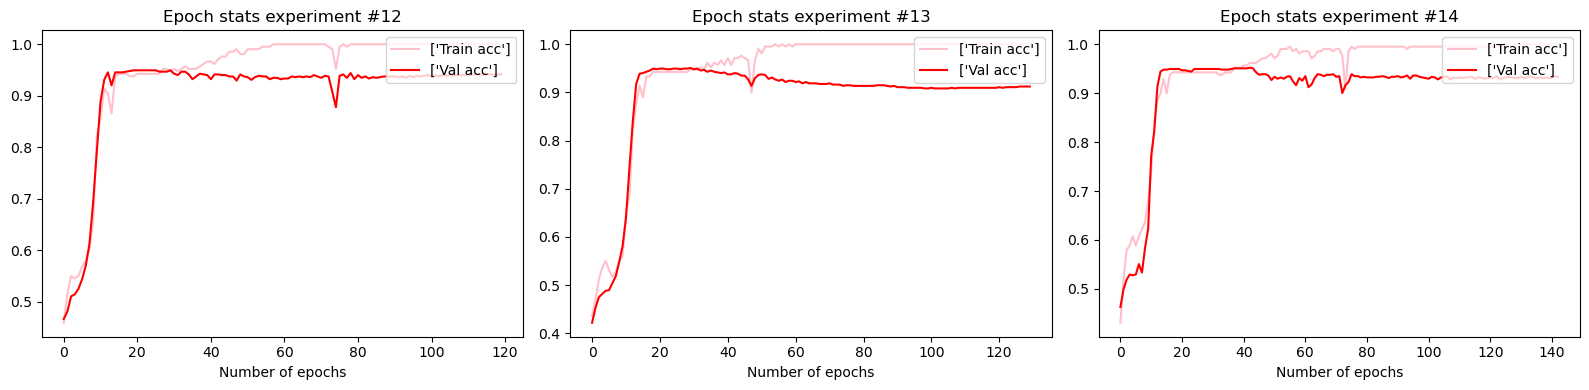

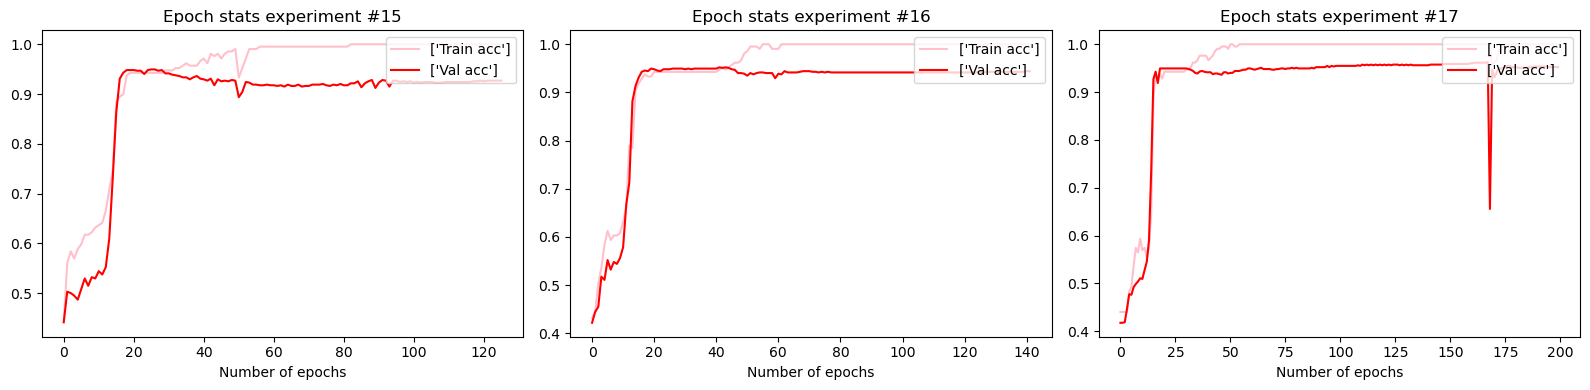

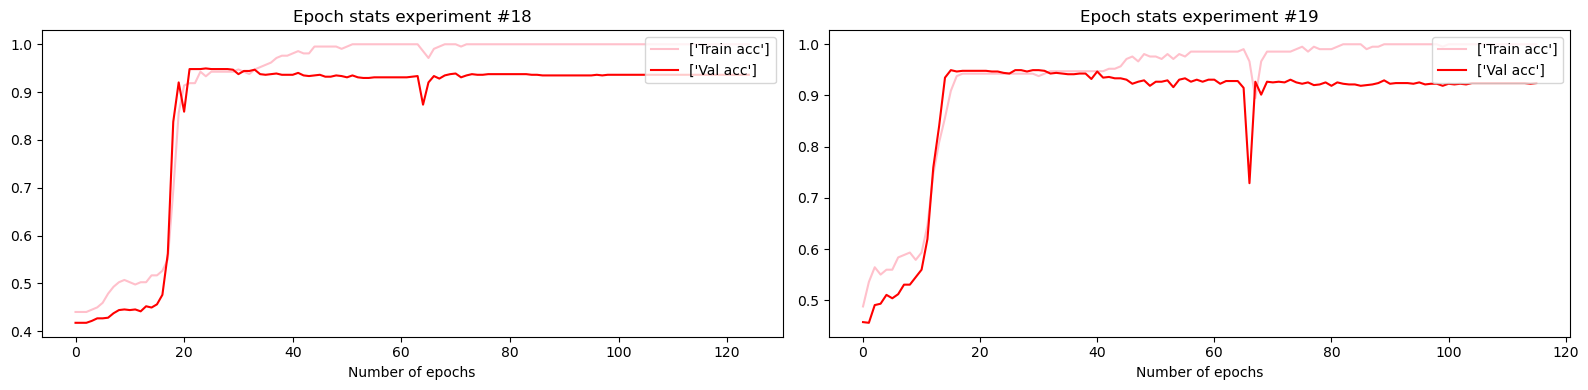

In [51]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

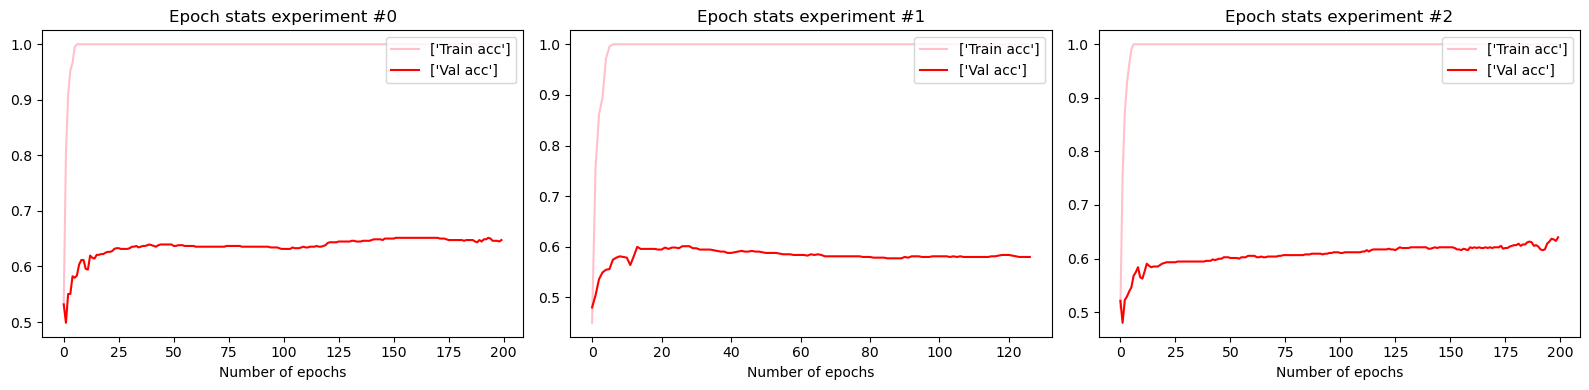

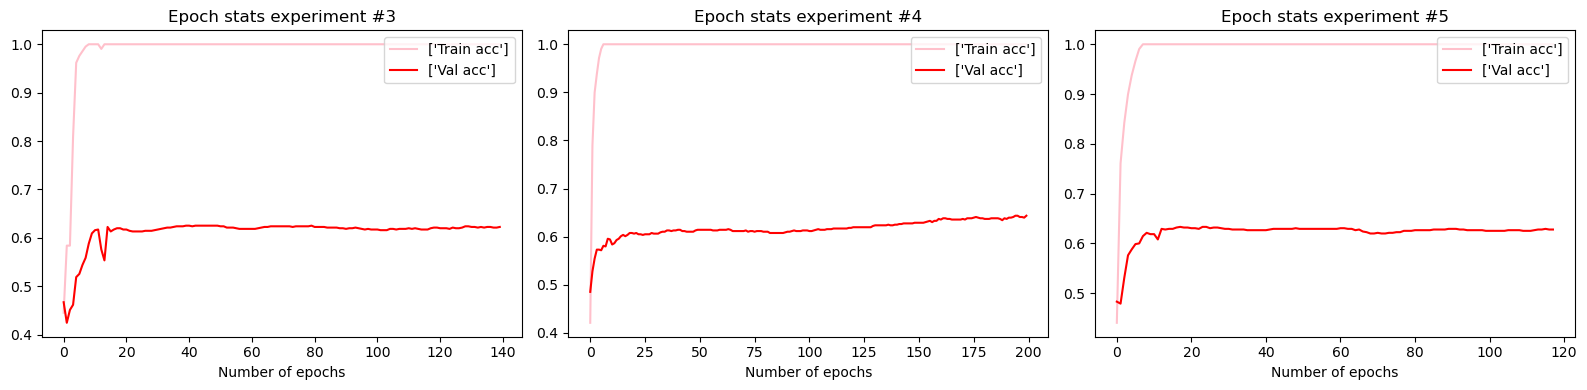

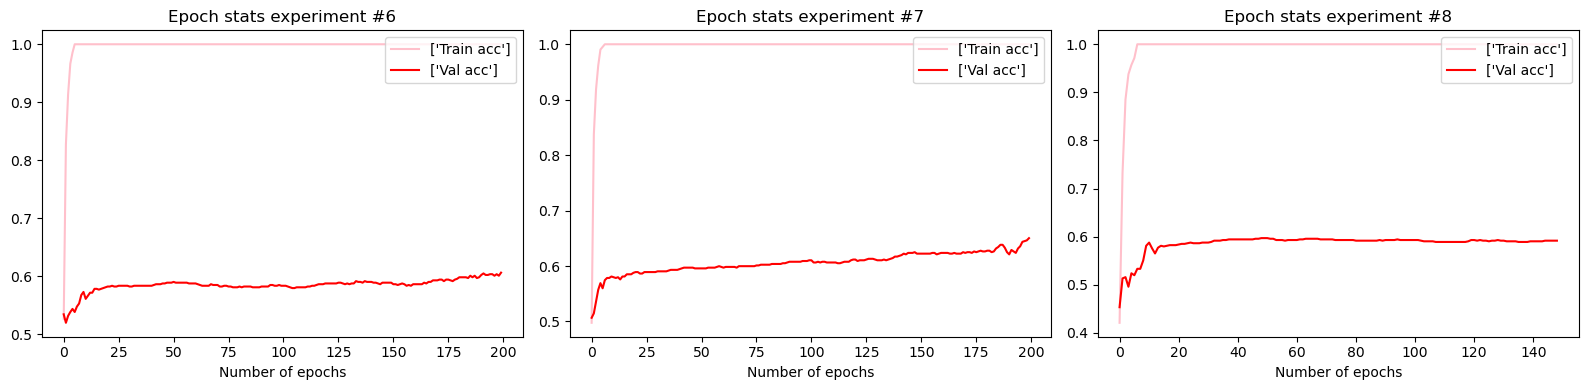

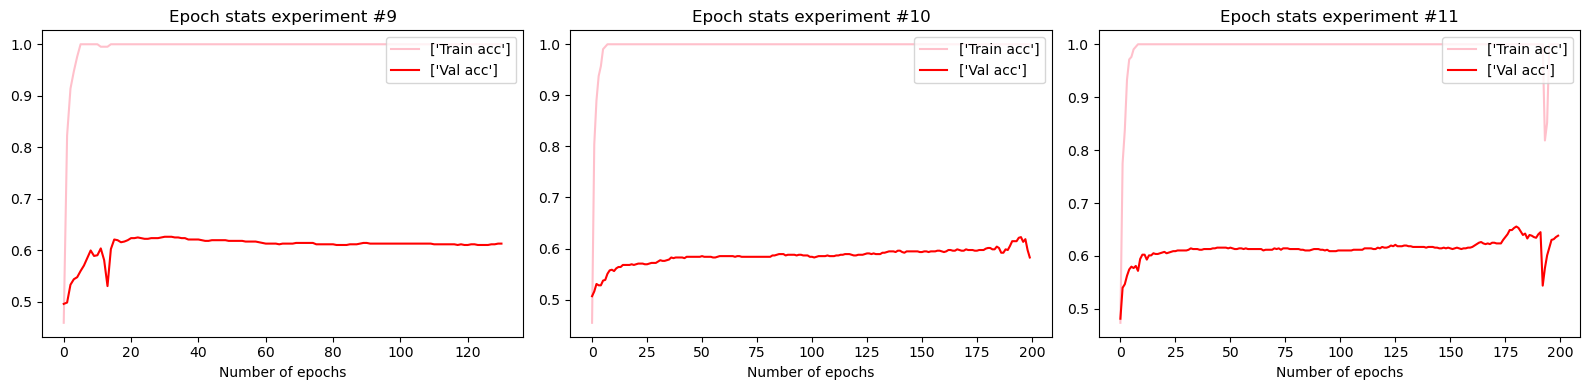

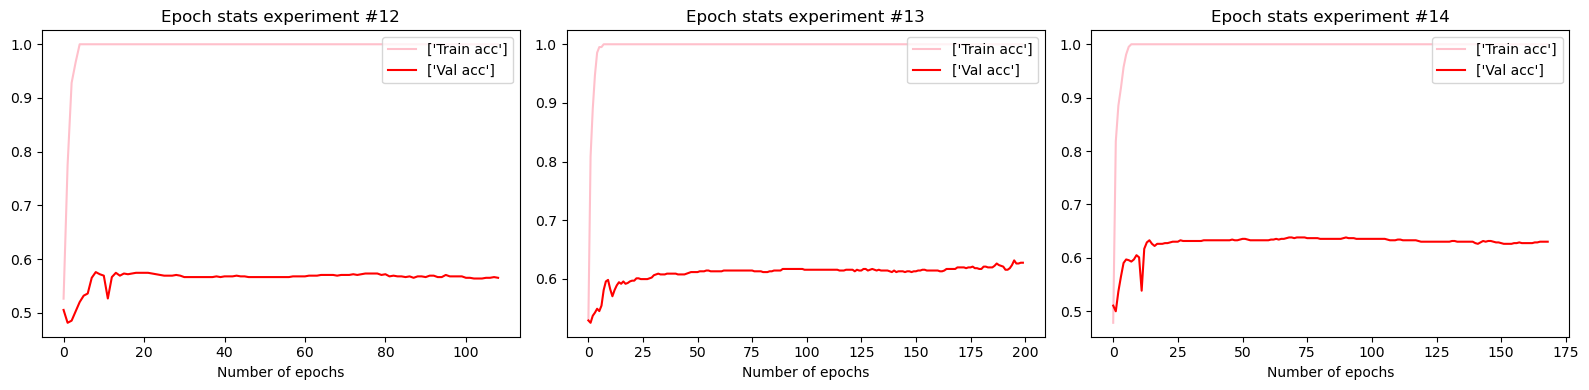

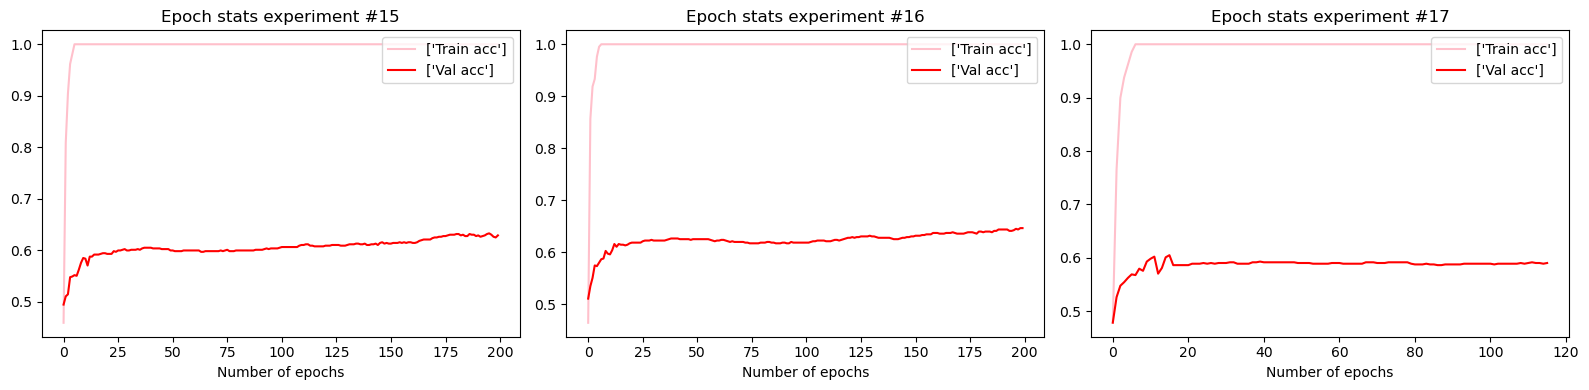

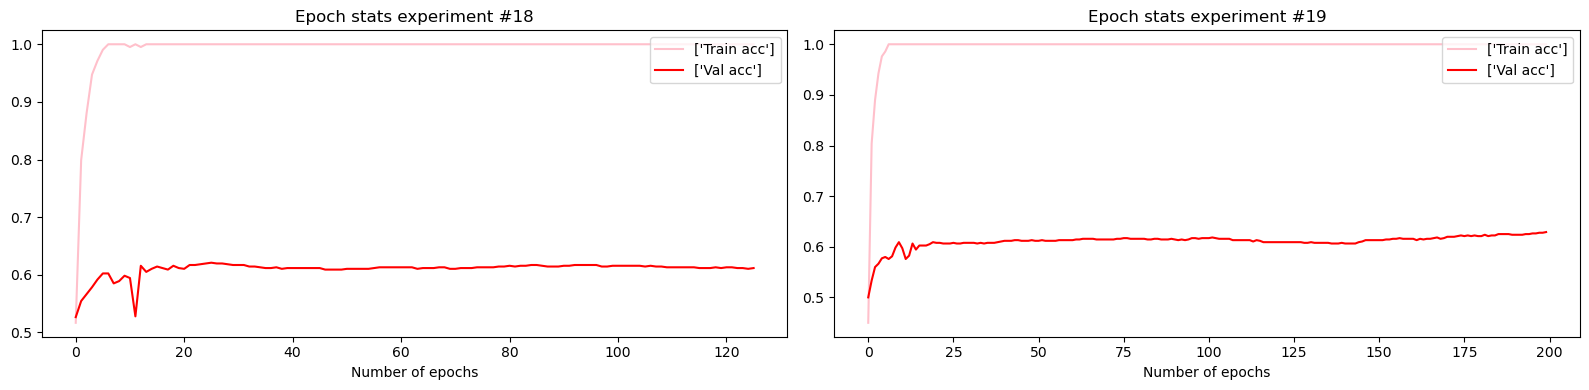

In [52]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

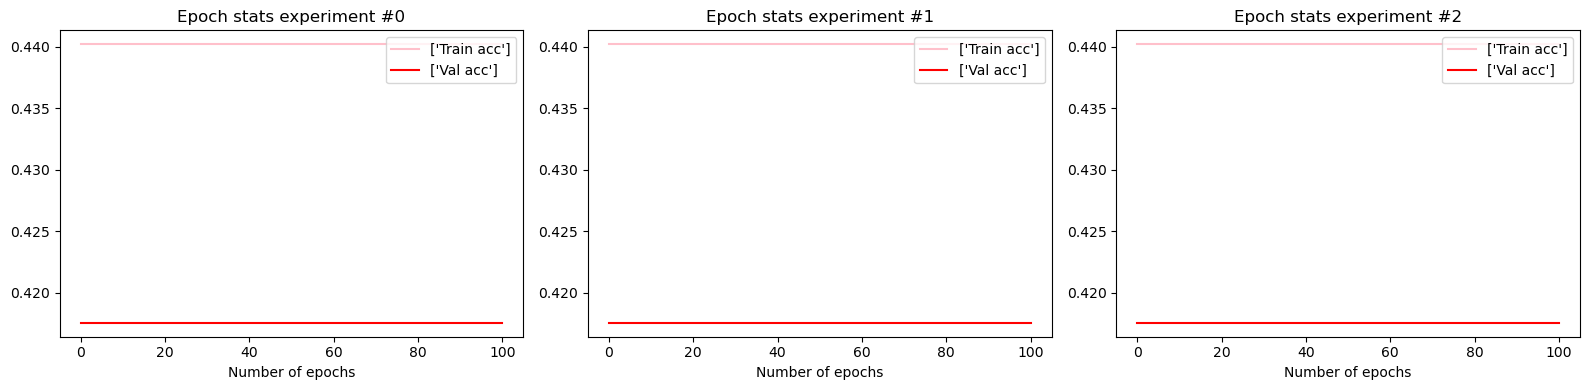

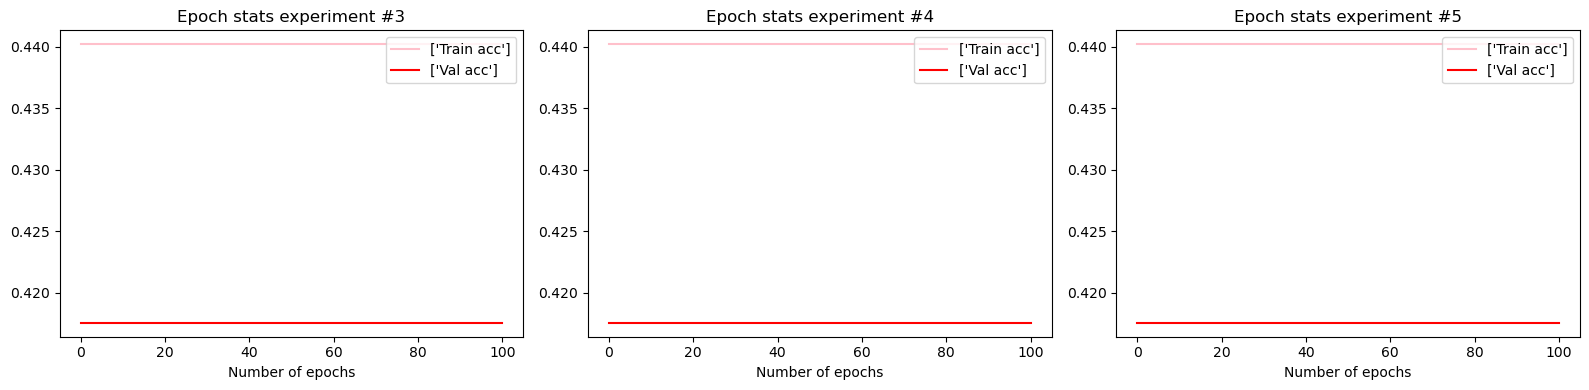

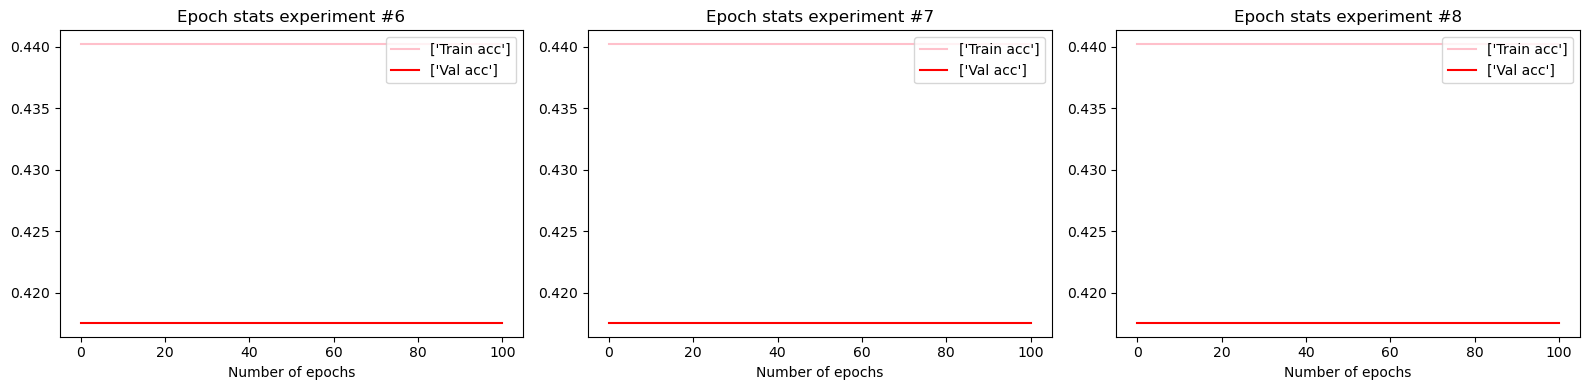

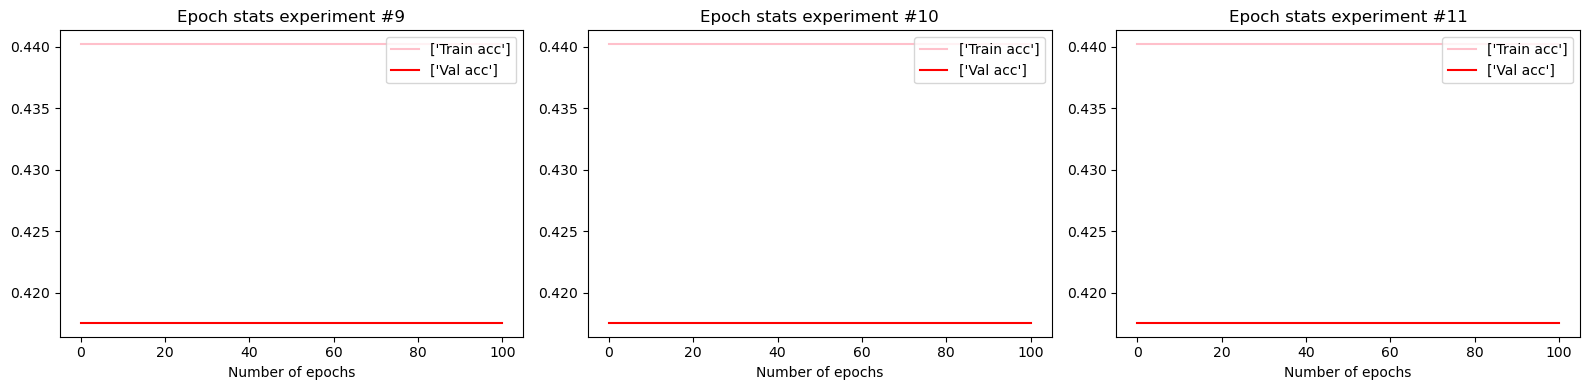

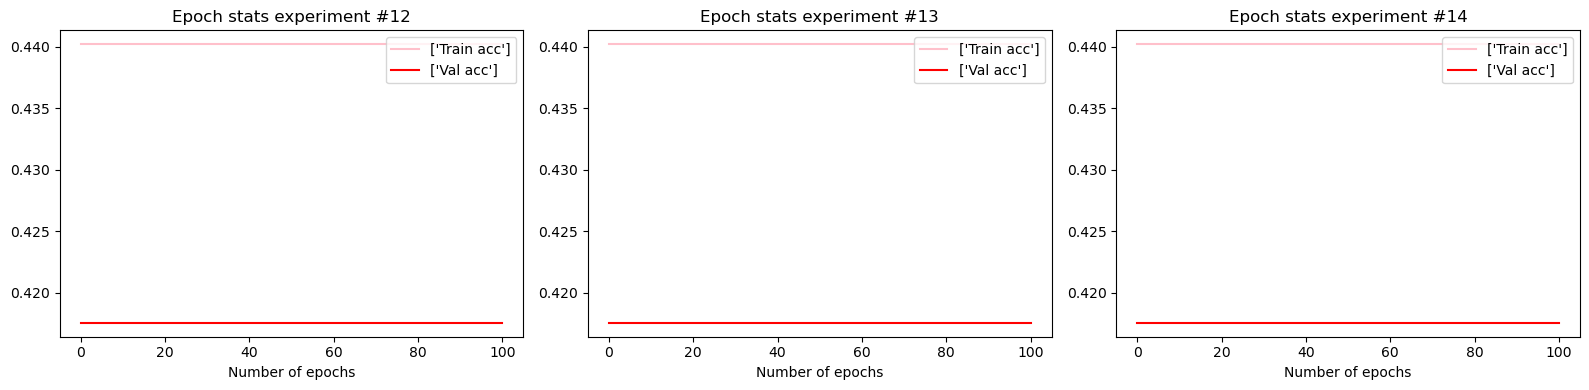

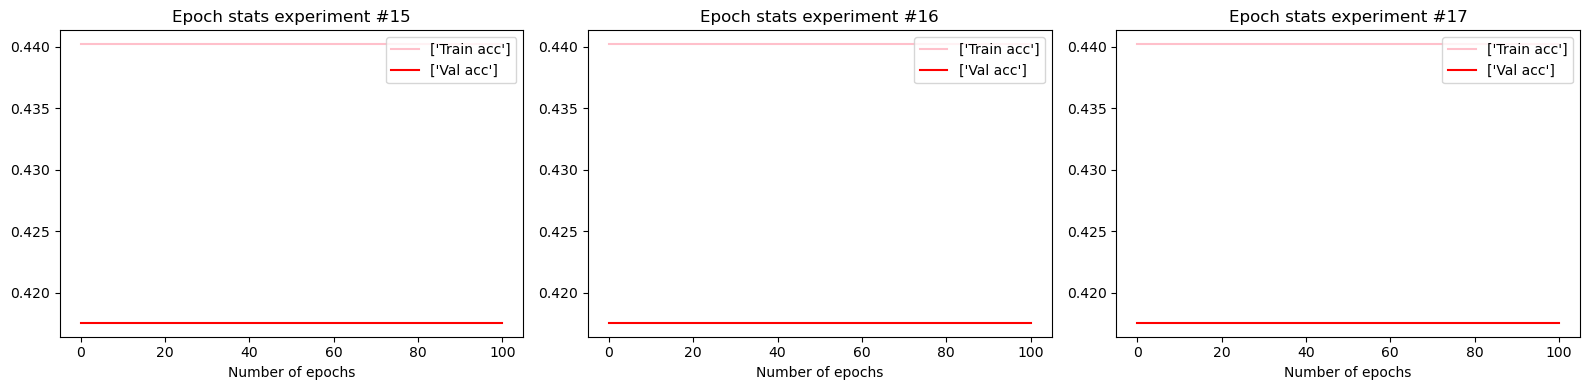

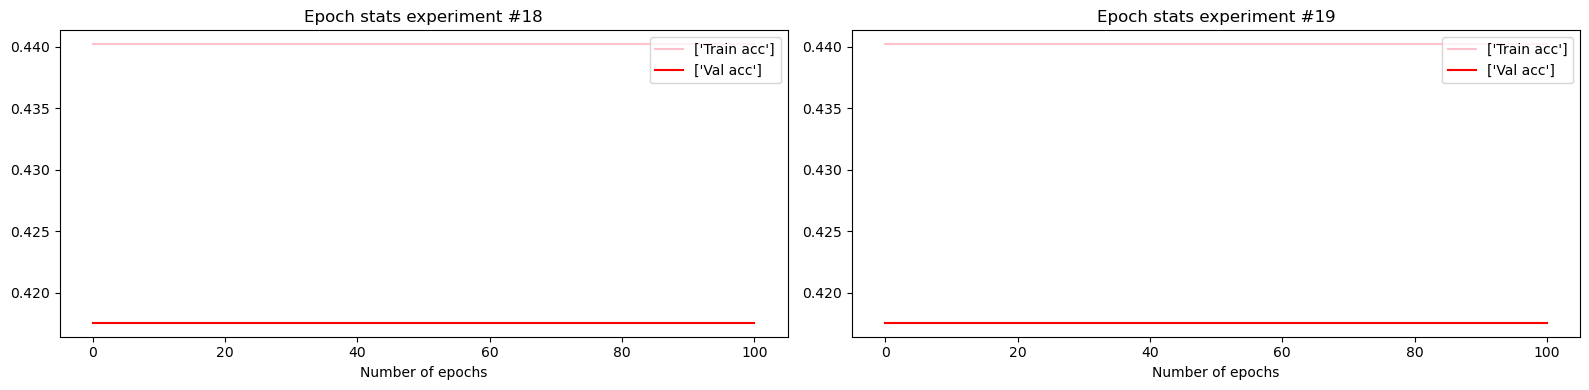

In [53]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

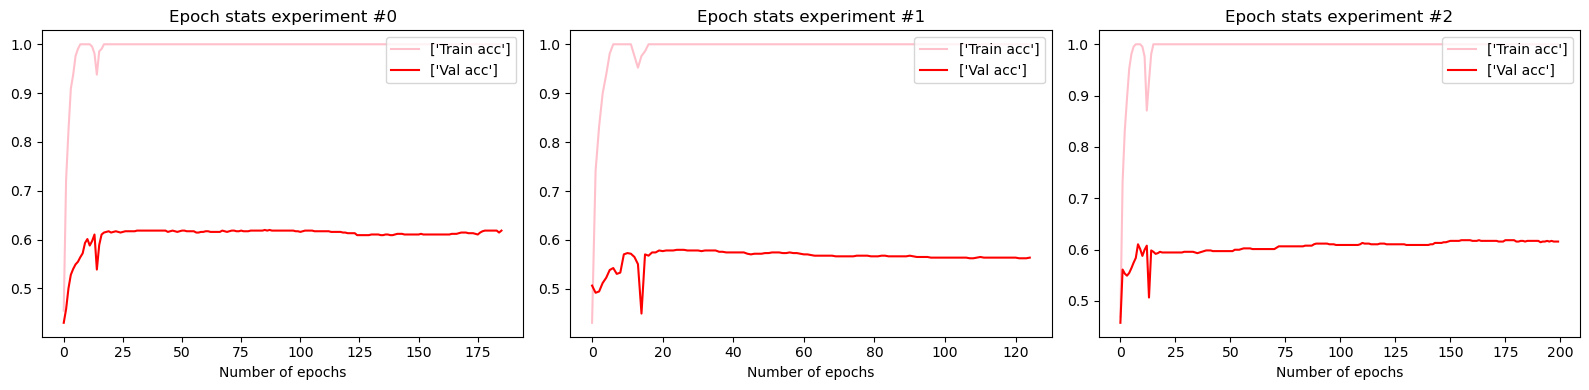

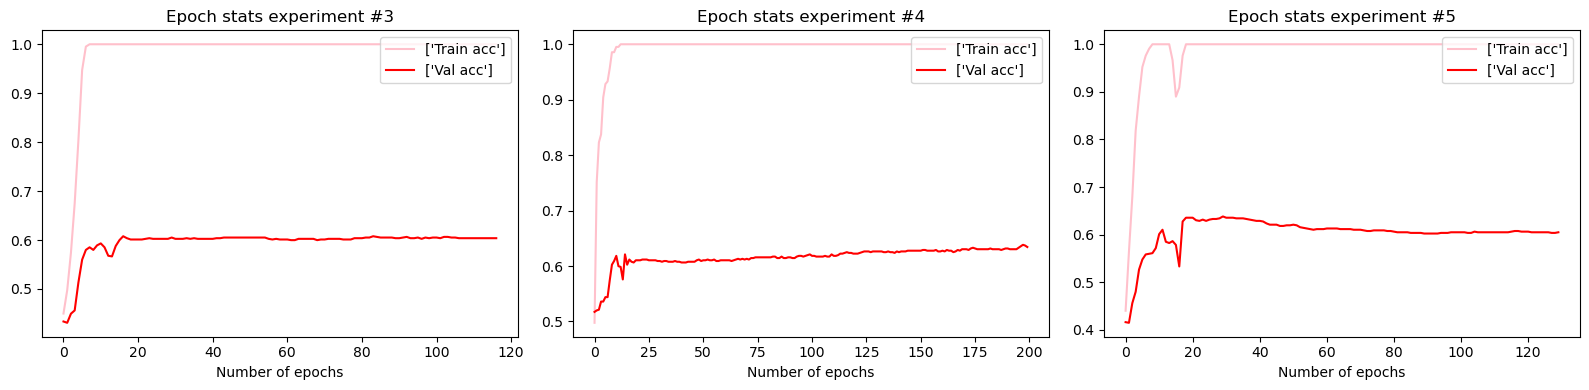

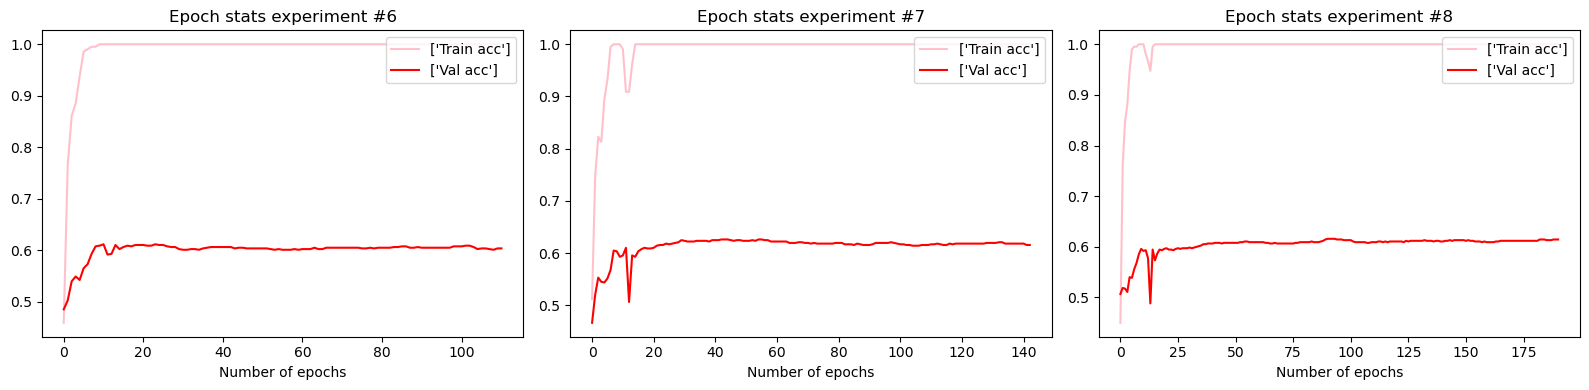

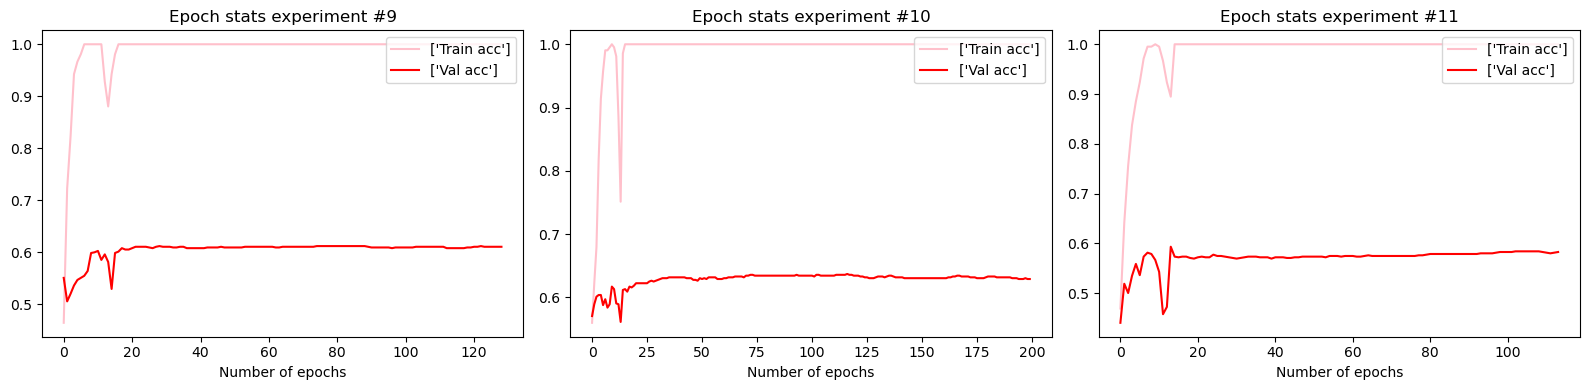

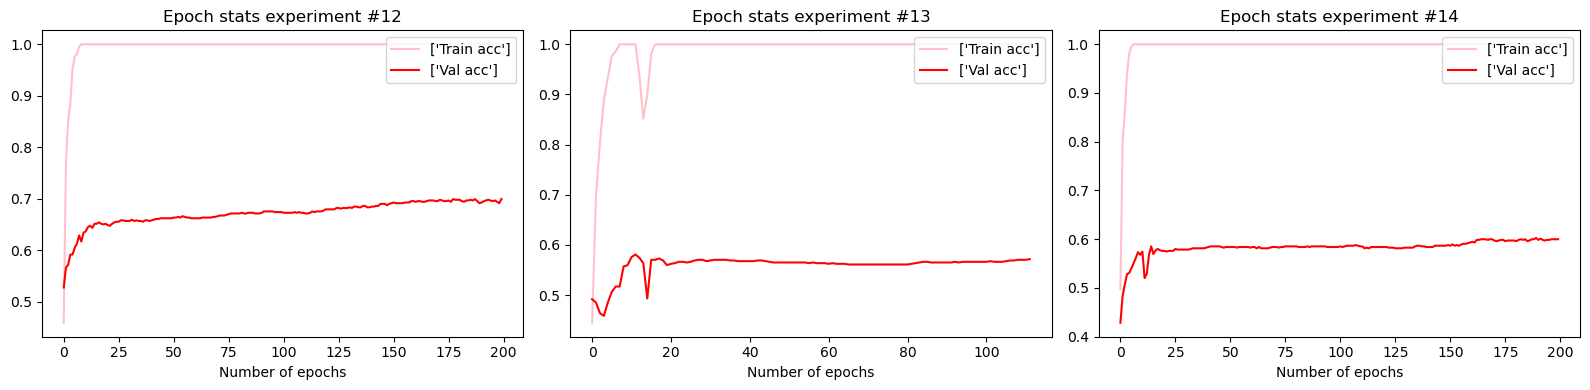

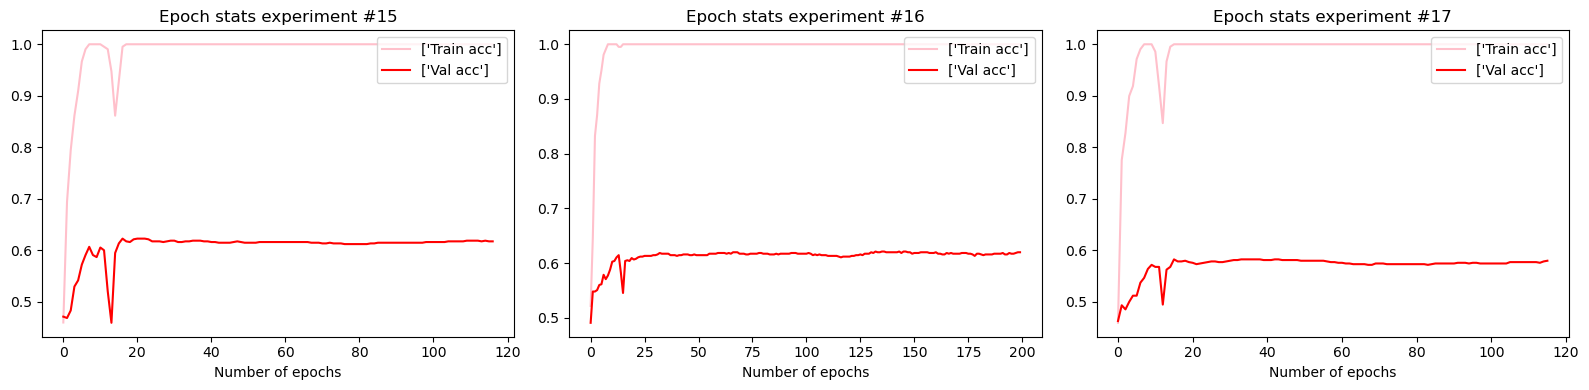

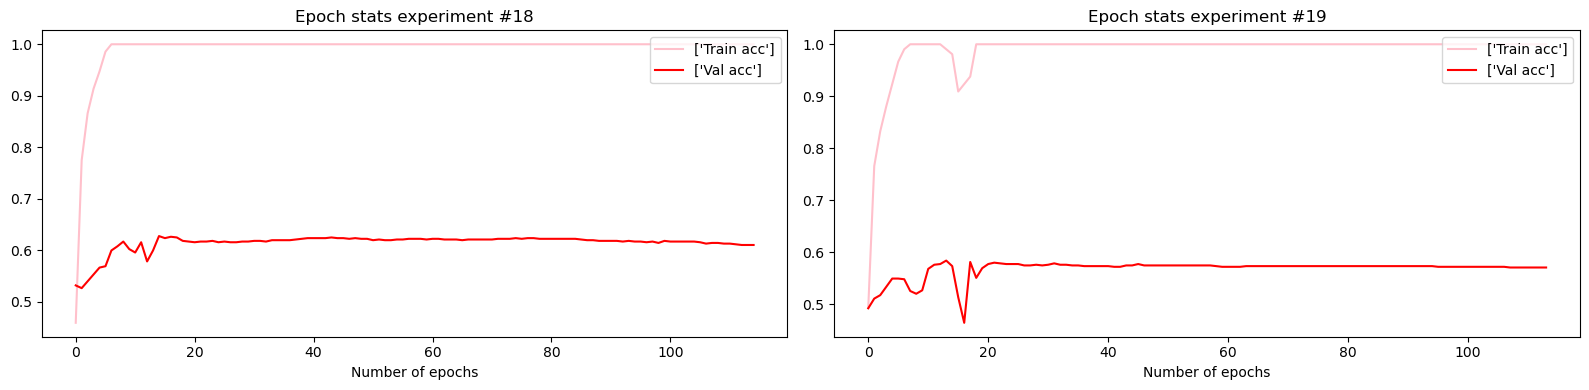

In [54]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [55]:
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model_skip19'))
best_cnn_model = CNN_Model(data, 64, 128, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model_skip19'))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('./bestmodels/best_DEEPSET_model_skip19'))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('./bestmodels/best_DEEPSETV2_model_skip19'))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('./bestmodels/best_FEEDFORWARD_model_skip19'))

C:\Users\juand\AppData\Local\Temp\ipykernel_45144\215661521.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_lstm_model.load_state_dict(torch.load('best_LSTM_model_s

<All keys matched successfully>

In [56]:
get_summary_df(["CNN", "LSTM", "DEEPSET", "DEEPSETv2", "FEEDFORWARD"], [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies], [cnn_precisions, lstm_precisions, deepset_precisions, deepsetv2_precisions, feedforward_precisions], [cnn_recalls, lstm_recalls, deepset_recalls, deepsetv2_recalls, feedforward_recalls], [cnn_f1s, lstm_f1s, deepset_f1s, deepsetv2_f1s, feedforward_f1s])

        Modelo  Accuracy  Precision    Recall  F1-score
0          CNN  0.971077   0.947140  0.989410  0.967814
1         LSTM  0.970745   0.941977  0.994705  0.967623
2      DEEPSET  0.644614   0.604979  0.551437  0.576969
3    DEEPSETv2  0.439495   0.439495  1.000000  0.610624
4  FEEDFORWARD  0.679854   0.637759  0.628593  0.633143


## Top wrong predictions for best performing CNN model

In [57]:
print_wrong_preds([get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original)], top_k=10)

Top 10 false positives: 

wu____,_._____.. ,...dr...,.._,.. | label: False | actual prediction: 0.9997801184654236
.,.,,,_wu,_,._,, __.,dr.,___,_,,_ | label: False | actual prediction: 0.9976086616516113
__..,_._,_,_,wu, ,,__,dr.._.__,.. | label: False | actual prediction: 0.9974090456962585
_,_wu,_,._,.,__. ,dr._,,,____,.._ | label: False | actual prediction: 0.99649578332901
,___._.,_.,,_wu, .,_.,.,,.,..dr,. | label: False | actual prediction: 0.9960973858833313
,_..,.,_,_.,__wu _.,,._,dr._.._,, | label: False | actual prediction: 0.9949990510940552
..._,_,_,,__wu_, ,,_._.._,dr.,,__ | label: False | actual prediction: 0.9943844079971313
,,_,,,_,..,_,_wu ,_,,,,.___.,,dr_ | label: False | actual prediction: 0.9935046434402466
,_wu_,__,,____,_ _.__,dr.,,,_,_., | label: False | actual prediction: 0.9929753541946411
__.,,,___,.wu__, ,_..dr,._.___,,_ | label: False | actual prediction: 0.9918941855430603

Top 10 false negatives: 

_..._,,_,wu,.,,, r,__,.._.,.,,._. | label: True | actual pr

## Top wrong predictions for best performing LSTM model

In [58]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

Top 10 false positives: 

_,_wu_,_,_,_._,_ _.dr.,.,,,,,_... | label: False | actual prediction: 0.9999524354934692
___,,__wu,_._,,. ,._.,_,_dr._.___ | label: False | actual prediction: 0.9999158382415771
,._,,_,,wu_____, ._..dr,_.,,.,_., | label: False | actual prediction: 0.9998537302017212
_,_wu,_,._,.,__. ,dr._,,,____,.._ | label: False | actual prediction: 0.9997984766960144
_,__,_wu,_,._,_. ,..,___.__,.,_dr | label: False | actual prediction: 0.9997441172599792
,_,_wu_,,.___.,_ _,_..,,,_.dr__,_ | label: False | actual prediction: 0.9997277855873108
.._,__.,wu_._.__ .,_,,.,_.__dr.,, | label: False | actual prediction: 0.999672532081604
,_wu_,__,,____,_ _.__,dr.,,,_,_., | label: False | actual prediction: 0.9996368885040283
,___.,wu_,.,,_.. ._.._,_,,.,._dr, | label: False | actual prediction: 0.9995300769805908
,,.,_,wu____,__, ,,dr,,.,_..___,. | label: False | actual prediction: 0.9994539618492126

Top 10 false negatives: 

.,.,,.,._,uw,.,, _.,,dr.,,,...,_. | label: True | actual p

## Top wrong predictions for best performing DeepSets V1 model

In [59]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

,.,_._._..uw.,., ,,,_.,,,__,,,_,, | label: False | actual prediction: 0.9999960660934448
,,,,._,._,.__wu. dr,...__,.,_,_., | label: False | actual prediction: 0.9999829530715942
_...._wu__,,_.,, ,,,_..,,.,_cr_,, | label: False | actual prediction: 0.9999821186065674
.,,_wu...,___,_, ,,...dr__.,..,_, | label: False | actual prediction: 0.9999773502349854
_,,_.w.._____._, ,,...,.,_,,_,_,, | label: False | actual prediction: 0.999974250793457
uw,...,,.,_,.,._ .,,_.,,..__,,_,, | label: False | actual prediction: 0.9999711513519287
._,,__,,_._,._.. .,,_.,,..,_.,_,. | label: False | actual prediction: 0.9999622106552124
.._.,_,__,,,__._ ,,_.,,,cr._._.,_ | label: False | actual prediction: 0.9999593496322632
wu.___...._,,.,. ,_._.,,..dr_,,._ | label: False | actual prediction: 0.9999575614929199
,,,uw_,.,.___.,_ ,,_..,._.,.___,, | label: False | actual prediction: 0.9999574422836304

Top 10 false negatives: 

___uw,_,,,_.,.__ __,dr_.._._,,._. | label: True | actual p

## Top wrong predictions for best performing DeepSets V2 model

In [60]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

.uw_._._,,_.,_,, __._,,.cr_,_,.,, | label: False | actual prediction: 0.6241759061813354

Top 10 false negatives: 

..,_,,w.__,__.,_ .,.,_.,.dr,.,.__ | label: True | actual prediction: 0.5
___,_w_____,._., _,,,_.,__,,,_r., | label: True | actual prediction: 0.5
_......___,_,_,, _._,_,,dr.__,.,. | label: True | actual prediction: 0.5
,_.._..,_.,uw,,_ ,dr._,__,_.,_.,. | label: True | actual prediction: 0.5
.,,w,..,,_,._,._ ,_.,.._,___r_,_. | label: True | actual prediction: 0.5
__,.__,,.,,.,w_, ._.,_.,_...dr,,. | label: True | actual prediction: 0.5
,..._,,_,uw,_._, ._,dr_,_._..__., | label: True | actual prediction: 0.5
._wu,_,.,,,_.,,_ _._,_.,r_._,_.,, | label: True | actual prediction: 0.5
_.____._._._,,__ ...,_.,_,r,,_,._ | label: True | actual prediction: 0.5
___,,,.w_,,._,,. ..,,_,__.,,,dr_. | label: True | actual prediction: 0.5




## Top wrong predictions for best performing Feedforward model

In [61]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

,,,,._,._,.__wu. dr,...__,.,_,_., | label: False | actual prediction: 0.9999998807907104
.._..._,_,,.wu_, ,_,.._,dr,_.__,_ | label: False | actual prediction: 0.9999979734420776
..._,_,_,,__wu_, ,,_._.._,dr.,,__ | label: False | actual prediction: 0.9999878406524658
wu.___...._,,.,. ,_._.,,..dr_,,._ | label: False | actual prediction: 0.999984860420227
,__,____._wu_.,_ _,_.,.,..dr_,,._ | label: False | actual prediction: 0.9999828338623047
.___._.__._.wu._ .,,..____.__,,dr | label: False | actual prediction: 0.999981164932251
,_uw,.._._...,,. ,,,.._,cr,_.,,,, | label: False | actual prediction: 0.9999790191650391
,.__wu_.._.,.,,_ ,,,..,.dr...__., | label: False | actual prediction: 0.9999784231185913
_wu.,_...,.____, ,,,_...,_,,,,__. | label: False | actual prediction: 0.9999783039093018
.,,_wu...,___,_, ,,...dr__.,..,_, | label: False | actual prediction: 0.9999754428863525

Top 10 false negatives: 

_._,,.,._.___.._ _.r.._..,..,.,_. | label: True | actual pr

# Saving Notebook State

In [ ]:
import dill
# dill.dump_session('notebook_env_skipping_19.db')

# Loading Notebook State

In [ ]:
import dill
dill.load_session('notebook_env_skipping_19.db')